In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [31]:
pic = cv2.imread('Images/sudoku.png');

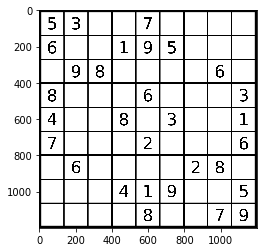

In [32]:
plt.imshow(pic, 'gray');

In [33]:
pic_gray = cv2.cvtColor(pic, cv2.COLOR_BGR2GRAY)

In [34]:
pic_gray = cv2.medianBlur(pic_gray, 5)

In [35]:
ths, pic_thresh = cv2.threshold(pic_gray, 100, 255, cv2.THRESH_BINARY);

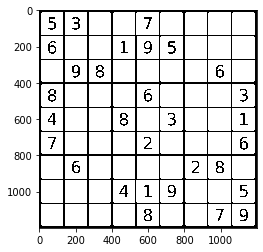

In [36]:
plt.imshow(pic_thresh, 'gray')

In [37]:
contours, h = cv2.findContours(pic_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


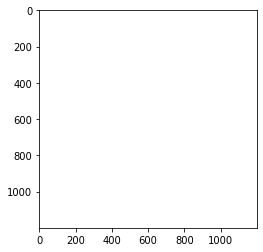

In [38]:
grid = np.ones(pic.shape, dtype = np.float32)*255;
plt.imshow(grid)

In [39]:
for i in range(len(contours)):
    if h[0][i][3] == -1:
        cv2.drawContours(grid, contours, i, (0, 255, 0), 5);

In [40]:
grid = cv2.cvtColor(grid, cv2.COLOR_BGR2GRAY);

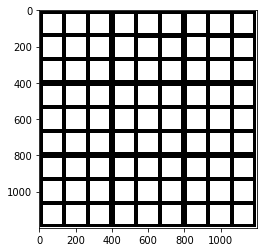

In [41]:
kernel = np.ones((5,5));
grid = cv2.erode(grid, kernel, iterations = 2);
grid = grid/255;
grid = grid.astype(np.uint8);
plt.imshow(grid, 'gray');

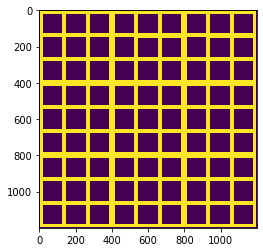

In [42]:
ths, grid_inv = cv2.threshold(grid.copy()*255, 127, grid.max(), cv2.THRESH_BINARY_INV);
plt.imshow(grid_inv);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


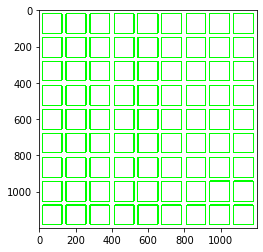

In [43]:
foundgrids = [];
temp = np.ones(pic.shape)
contours, h = cv2.findContours(grid_inv, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE);
for i,cnt in enumerate(contours):
    (x,y,w,h) = cv2.boundingRect(cnt);
    if w in range(105, 116) and h in range(105, 116):
        foundgrids.append([x,y,w,h]);
        cv2.drawContours(temp, contours, i, (0, 255, 0), 5);
plt.imshow(temp)

In [44]:
tempgrids = sorted(foundgrids);
foundgrids = [];
for i in range(9):
    foundgrids.extend(sorted(tempgrids[i*9:i*9+9], key = lambda tempgrids: tempgrids[1]));
foundpics = [];
for i, e in enumerate(foundgrids):
    x,y,w,h = e[0],e[1], e[2], e[3];
    temp = pic[x:x+w, y:y+h];
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2GRAY);
    temp = cv2.resize(temp, (28,28));
#     ths, temp_thresh = cv2.threshold(temp, 127, temp.max(), cv2.THRESH_BINARY_INV)
#     temp_thresh = temp_thresh.reshape((28,28,1));
    temp = cv2.bitwise_not(temp);
#     temp = temp.reshape((28,28,1));
    foundpics.append(temp);
foundpics = np.array(foundpics)

In [45]:
foundpics[9] = foundpics[53]

In [46]:
# for i, x in enumerate(foundpics):
#     plt.title(i);
#     plt.imshow(x.reshape((28,28)), 'gray');
#     plt.show();

In [47]:
from tensorflow.keras.models import load_model
model = load_model('Model/mnistmodel.h5');

In [48]:
import copy
j = -1;
arr = [[] for i in range(9)];
for i, x in enumerate(foundpics):
    num0b = len(x[x == x.min()]);
    num1b = len(x[x == 255]);
    if(i%9 == 0):
        j+=1;
    if num1b/(num0b+num1b) >= 0.03:    
        x_t = x.reshape((1,28,28,1))/255;
        y_pred = model.predict_classes(x_t);      
        arr[j].append(y_pred[0]);
    else:
        arr[j].append(0);
arr_tf = copy.deepcopy(arr);
for i in range(len(arr_tf)):
    for j in range(len(arr_tf[i])):
        if(arr_tf[i][j] != 0):
            arr_tf[i][j] = 1;
arr_tf
arr

[[5, 3, 0, 0, 7, 0, 0, 0, 0],
 [6, 0, 0, 1, 9, 5, 0, 0, 0],
 [0, 9, 8, 0, 0, 0, 0, 6, 0],
 [8, 0, 0, 0, 6, 0, 0, 0, 3],
 [4, 0, 0, 8, 0, 3, 0, 0, 1],
 [7, 0, 0, 0, 2, 0, 0, 0, 6],
 [0, 6, 0, 0, 0, 0, 2, 8, 0],
 [0, 0, 0, 4, 1, 9, 0, 0, 5],
 [0, 0, 0, 0, 8, 0, 0, 7, 9]]

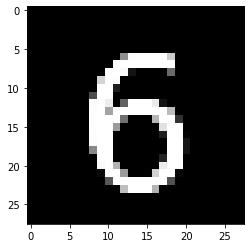

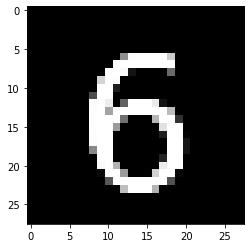

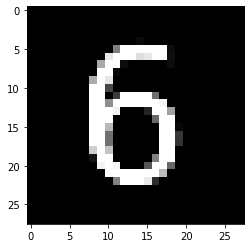

[6] [6] [6]


In [49]:
x = foundpics[9]/255;
plt.imshow(foundpics[9], 'gray');
plt.show();
y1 = model.predict_classes(x.reshape(1,28,28,1));
x = foundpics[53]/255
plt.imshow(x, 'gray');
plt.show();
y2 = model.predict_classes(x.reshape(1,28,28,1));
x = foundpics[55]/255;
plt.imshow(x, 'gray');
plt.show();
y3 = model.predict_classes(x.reshape(1,28,28,1));
print(y1,y2,y3)
x = x.reshape(1,28,28,1);
x = x/255;

In [50]:
def find_empty_location(arr, l): 
    for row in range(9): 
        for col in range(9): 
            if(arr[row][col]== 0): 
                l[0]= row 
                l[1]= col 
                return True
    return False

def used_in_row(arr, row, num): 
    for i in range(9): 
        if(arr[row][i] == num): 
            return True
    return False

def used_in_col(arr, col, num): 
    for i in range(9): 
        if(arr[i][col] == num): 
            return True
    return False
  
def used_in_box(arr, row, col, num): 
    for i in range(3): 
        for j in range(3): 
            if(arr[i + row][j + col] == num): 
                return True
    return False
  
def check_location_is_safe(arr, row, col, num): 
    return not used_in_row(arr, row, num) and not used_in_col(arr, col, num) and not used_in_box(arr, row - row % 3, col - col % 3, num) 

def solve_sudoku(arr):       
    l =[0, 0]       
    if(not find_empty_location(arr, l)): 
        return True
      
    row = l[0] 
    col = l[1] 
      
    for num in range(1, 10):           
        if(check_location_is_safe(arr, row, col, num)):               
            arr[row][col]= num 
  
            if(solve_sudoku(arr)): 
                return True
  
            arr[row][col] = 0
              
    return False 

In [51]:
solve_sudoku(arr);

In [52]:
arr

[[5, 3, 4, 6, 7, 8, 9, 1, 2],
 [6, 7, 2, 1, 9, 5, 3, 4, 8],
 [1, 9, 8, 3, 4, 2, 5, 6, 7],
 [8, 5, 9, 7, 6, 1, 4, 2, 3],
 [4, 2, 6, 8, 5, 3, 7, 9, 1],
 [7, 1, 3, 9, 2, 4, 8, 5, 6],
 [9, 6, 1, 5, 3, 7, 2, 8, 4],
 [2, 8, 7, 4, 1, 9, 6, 3, 5],
 [3, 4, 5, 2, 8, 6, 1, 7, 9]]

In [53]:
k = 0;
picc = pic.copy();
for i in range(9):
    for j in range(9):
        if arr_tf[i][j] == 0:
            x,y,w,h = foundgrids[k];
            cv2.putText(picc, text = str(arr[i][j]), org = (y+5, x+w-5), fontFace = cv2.FONT_HERSHEY_COMPLEX, fontScale = 3, color = (255, 0, 0), thickness = 10);
        k+=1;

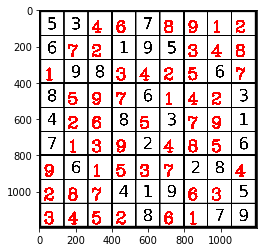

In [54]:
plt.imshow(picc)

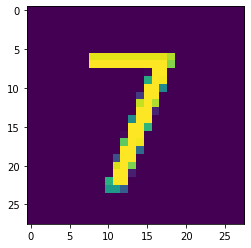

In [55]:
plt.imshow(foundpics[45])